Trains the model with the whole genome training data for DELs (DEL_start and DEL_end) + noSV

## Load dependencies and setting output configuration

In [1]:
import numpy as np
from keras.utils.np_utils import to_categorical
import keras
import gzip
from collections import Counter

%pylab inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


## Load data from npy files

In [4]:
sample_name = 'G1'
context_dict = {'G1': 'train', 'G2': 'train', 'N1': 'real'}
#date = '230718' # '010618'
date = '111018'
win = '50bp'

#datapath='/Users/lsantuari/Documents/Data/HPC/DeepSV/' + date + '/TrainingData_' + date + '/'+sample_name+'/ChannelData/'
# datapath='/hpc/cog_bioinf/ridder/users/lsantuari/Processed/Test/' + date + '/TrainingData_' + date + '/'+sample_name+'/ChannelData/'


In [8]:
# Load channel data and labels by chromosome

#Leaving out chromosome Y and MT for the moment
chr_list = list(map(str, np.arange(1,2)))
#chr_list.append('X')
print(chr_list)

data = []
labels = []

for sample_name in ['G1', 'G2', 'N1']:
    
    print('Considering sample %s' % sample_name)
    
    #datapath='/Users/lsantuari/Documents/Data/HPC/DeepSV/' + date + '/TrainingData_' + date + '/'+sample_name+'/ChannelData/'
    #datapath_labels = '/Users/lsantuari/Documents/Data/HPC/DeepSV/' + date + '/TrainingData_' + date + '/'+sample_name+'/LabelData/'
    
    datapath='/hpc/cog_bioinf/ridder/users/lsantuari/Processed/Test/' + date + '/' + win + '/TrainingData_' + date + '/'+sample_name+'/ChannelData/'
    datapath_labels = '/hpc/cog_bioinf/ridder/users/lsantuari/Processed/Test/' + date + '/'+win+'/TrainingData_' + date + '/'+sample_name+'/LabelData/'
    
    #filename = '_channel_maker_'+context_dict[sample_name]+'_germline.npy.gz'
    
    for i in chr_list:
    #for i in [16, 17, 18]:

        filename = sample_name + '_' + str(i) + '.npy.gz'
        
        print('Loading data and labels for Chr%s' % i)
        #data_file = datapath + str(i) + filename
        data_file = datapath + filename
        with gzip.GzipFile(data_file, "rb") as f:
            data_mat = np.load(f)
            data.extend(data_mat)
        f.close()

        label_file = datapath_labels + sample_name + '_' + str(i) + '_label.npy.gz'

        with gzip.GzipFile(label_file, "rb") as f:
            data_lab = np.load(f)
            #The list still includes a value (0) at position 0 that
            #makes the window boundaries fall off the chromosome boundaries
            #if i == '17':
            #    data_lab = data_lab[1:]
            labels.extend(data_lab)
        f.close()
        # print('Length of data:%d, label length:%d' % (len(data_mat), len(data_lab)))
        assert len(data_mat) == len(data_lab)

data = np.array(data)
labels = np.array(labels)

print(Counter(labels))
assert len(data) == len(labels)

#X_test=data[np.where(labels != 'no_del')]
#y_test = labels[np.where(labels != 'no_del')]
#X_test = X_test[:, [0,1,2,11,12,13], :]
#data = []
#labels = []

['1']
Considering sample G1
Loading data and labels for Chr1
Considering sample G2
Loading data and labels for Chr1
Considering sample N1
Loading data and labels for Chr1
Counter({'noSV': 117905, 'INS_pos': 59694, 'DEL_end': 28508, 'DEL_start': 28449})


In [9]:
data.shape

(234556, 38, 50)

In [59]:
# Select 5 channels
ch_idx = [0,1,2,19,20]
data = data[:,ch_idx,:]

In [4]:
%%time
# Save data and labels

data_output_file = datapath + '../../X.npy.gz'
with gzip.GzipFile(data_output_file, "wb") as f:
    np.save(f, data)
f.close()

label_output_file = datapath + '../../y.npy.gz'
with gzip.GzipFile(label_output_file, "wb") as f:
    np.save(f, labels)
f.close()

CPU times: user 53min 18s, sys: 1min 31s, total: 54min 49s
Wall time: 54min 50s


In [ ]:
%%time
# Load data and labels

data_output_file = datapath + '../../X.npy.gz'
with gzip.GzipFile(data_output_file, "rb") as f:
    data = np.load(f)
f.close()

label_output_file = datapath + '../../y.npy.gz'
with gzip.GzipFile(label_output_file, "rb") as f:
    labels = np.load(f)
f.close()

In [4]:
print(data_output_file)

NameError: name 'data_output_file' is not defined

In [10]:
#Do not consider insertions: remove INS_pos
no_ins = np.where(np.array(labels)!='INS_pos')
data = data[no_ins]
labels = labels[no_ins]

In [ ]:
#Relabel deletions
# del_idx = np.where(np.logical_or(np.array(labels)=='DEL_start',np.array(labels)=='DEL_end'))
# print(del_idx)
# print(len(del_idx))
# print(len(labels))
# labels[del_idx] = 'DEL'

In [11]:
cnt_lab = Counter(labels)
#print([v for k, v in cnt_lab.items()])
min_v = min([v for k, v in cnt_lab.items()])

print(cnt_lab)
print('Minimum number of labels = ' + str(min_v))
#np.concatenate(data[np.where(labels == 'noSV')][]

Counter({'noSV': 117905, 'DEL_end': 28508, 'DEL_start': 28449})
Minimum number of labels = 28449


In [12]:
#Balance data

data_balanced = []
labels_balanced = []

for l in cnt_lab.keys():
    print(l)
    iw = np.where(np.array(labels)==l)
    #print(iw[0])
    ii = np.random.choice(a=iw[0], size=min_v, replace=False)
    data_balanced.extend(data[ii])
    labels_balanced.extend(labels[ii])

print(Counter(labels_balanced))

DEL_start
DEL_end
noSV
Counter({'DEL_start': 28449, 'DEL_end': 28449, 'noSV': 28449})


In [13]:
X = np.array(data_balanced)
y = np.array(labels_balanced)

In [18]:
# Selecting only a few channels
#indices = np.array([0,1,2,9,12,15,18,19,20,23,26])
#X = X[:,indices,:]

#include_ii = np.where(y!='noSV')
#X = X[include_ii]
#y = y[include_ii]

In [14]:
X.shape

(85347, 38, 50)

In [15]:
y.shape

(85347,)

### Number of channels

In [16]:
number_channels = X.shape[1]
number_channels

38

In [18]:
#Split into training, validation and test set 60/20/20
cnt_lab = Counter(labels_balanced)
n_lab = [v for v in cnt_lab.values()][0]
i_train = int(n_lab*0.6)
i_val = i_train + int(n_lab*0.1)
print(i_train)
print(i_val)

X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []

for l in cnt_lab.keys():
    iw = np.where(y==l)
    #print(iw[0])
    #print(iw[0][:i_train])
    X_train.extend(X[iw[0][:i_train]])
    X_val.extend(X[iw[0][i_train:i_val]])
    X_test.extend(X[iw[0][i_val:]])
    
    y_train.extend(y[iw[0][:i_train]])
    y_val.extend(y[iw[0][i_train:i_val]])
    y_test.extend(y[iw[0][i_val:]])

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)


17069
19913
(51207, 38, 50)
(8532, 38, 50)
(25608, 38, 50)
(51207,)
(8532,)
(25608,)


## Normalize data

In [ ]:
#coverage = np.median(X_train[:, 0, :]) #the median of the coverage in the normal cells
#coverage

#NA12878 median insert size: 368
#expected coverage:
hg19_len = 3095693981
read_len = 150
coverage = int(976976324 * read_len / hg19_len)
print(coverage)

In [ ]:
#not used now

expected_distance = 368

def normalize(X):       
    for i in range (0, len(X)):            
        for k in [3,5]:
            X[i][k] = np.divide(X[i][k],  X[i][1]/2 + 1/(10*X[i][1]+1)) #divide by number of clips
        for k in [4,6]:            
            X[i][k] = np.divide(X[i][k],  X[i][2]/2 +  1/(10*X[i][2]+1))
        for k in [3+11,5+11]:
            X[i][k] = np.divide(X[i][k],  X[i][1+11]/2 +  1/(10*X[i][12]+1))
        for k in [4+11,6+11]:            
            X[i][k] = np.divide(X[i][k],  X[i][2+11]/2+  1/(10*X[i][13]+1))
        for k in [3,4,5,6,14,15,16,17]:#the distance channels
            X[i][k] = np.divide(X[i][k], expected_distance)
        for j in range(0,number_channels):                                                                             
            X[i][j] = np.divide(X[i][j], coverage)*100
            
#normalize(X_train)
#normalize(X_val)
#normalize(X_test)

In [ ]:
#not used now

expected_distance = 150
def normalize(X):       
    for i in range (0, len(X)):                    
        for k in [3,4,5,6,14,15,16,17]:#the distance channels
            X[i][k] = np.divide(X[i][k], expected_distance)
        for j in range(0,number_channels):                                                                             
            X[i][j] = np.divide(X[i][j], coverage)*100     
normalize(X_train)
#normalize(X_val)
#normalize(X_test)

## Plots several  windows 

In [68]:
n_windows = X_train.shape[0]


In [24]:
# 27 channels

label = ["None"] * number_channels

label[0] = "cov"
label[1] = "L_CR"
label[2] = "R_CR"

label[3] = "INV_B"
label[4] = "INV_A"
label[5] = "R_CR_DUP_B"
label[6] = "L_CR_DUP_A"

label[7] = "F_L_CR_sum"
label[8] = "F_L_CR_num"
label[9] = "F_L_CR_med"
label[10] = "F_R_CR_sum"
label[11] = "F_R_CR_num"
label[12] = "F_R_CR_med"

label[13] = "R_L_CR_dist_sum"
label[14] = "R_L_CR_dist_num"
label[15] = "R_L_CR_dist_med"
label[16] = "R_R_CR_dist_sum"
label[17] = "R_R_CR_dist_num"
label[18] = "R_R_CR_dist_med"

label[19] = "L_SR"
label[20] = "R_SR"

label[21] = "L_SR_dist_sum"
label[22] = "L_SR_dist_num"
label[23] = "L_SR_dist_med"

label[24] = "R_SR_dist_sum"
label[25] = "R_SR_dist_num"
label[26] = "R_SR_dist_med"

IndexError: list assignment index out of range

In [69]:
# 27 channels

label = ["None"] * number_channels

label[0] = "cov"
label[1] = "L_CR"
label[2] = "R_CR"
label[3] = "L_SR"
label[4] = "R_SR"

In [70]:
from numpy import *
import math
import matplotlib.pyplot as plt

colors =['b','g', 'm', 'gray', 'r','c', 'darkgreen' ,'y', 'k', 'orange', 'gray']

def plot_channels(start_window, n_windows):
    for i in range (start_window, start_window + n_windows, 5):
        print(y_train[i], 'id:', i)
        #print('id:', i)
        for j in range (0, number_channels):   
            if j in [3, 6, 14, 17]:
                continue
            shift = 0
            start =0
            if j in [0,11]:
                shift = -100
            if j > 10:
                start = -60
            Z = [start + shift + 300 + x - 5*j*4 for x in X_train[i][j]]  
            #plt.ylim([100,700])
            if np.max(Z) > 1000:
                plt.ylim([-200,1000])
                Z = [start + shift + 300 + x - 5*j*4 - 400 for x in X_train[i][j]]  
            if j>10:
                plt.plot(Z,  label = label[j], linestyle=':', linewidth=1.5, color = colors[j % 11])
            else:
                plt.plot(Z, label = label[j], color = colors[j])
        
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 20})    
        plt.show()

26625
DEL_start id: 0


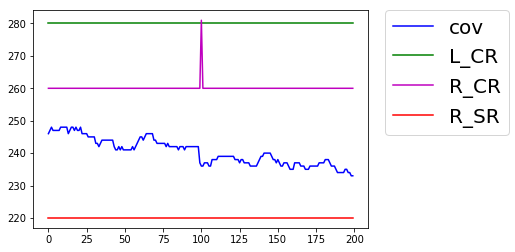

DEL_start id: 5


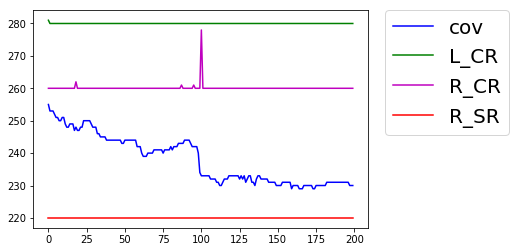

DEL_start id: 10


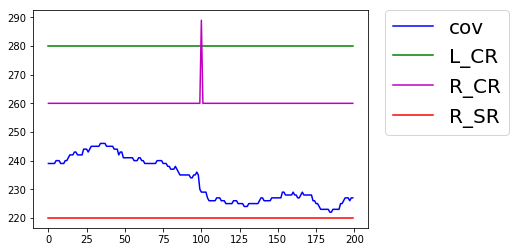

DEL_start id: 15


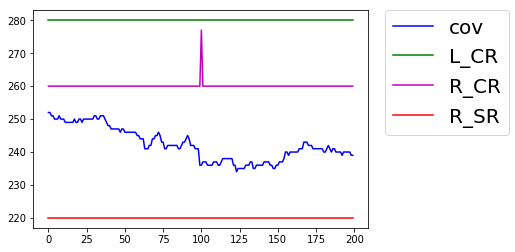

DEL_start id: 20


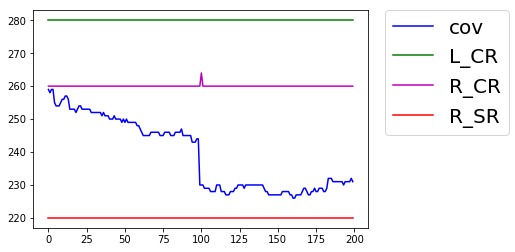

DEL_start id: 25


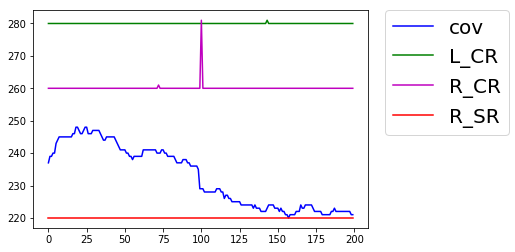

DEL_start id: 30


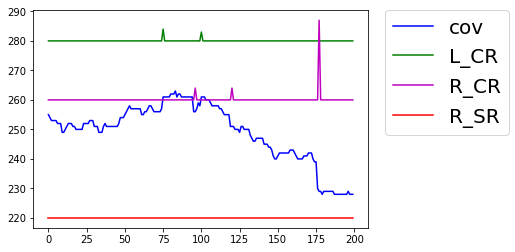

DEL_start id: 35


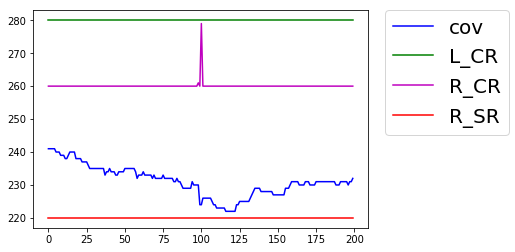

DEL_start id: 40


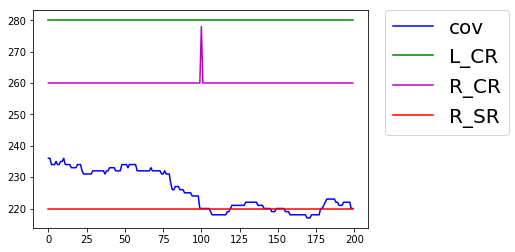

DEL_start id: 45


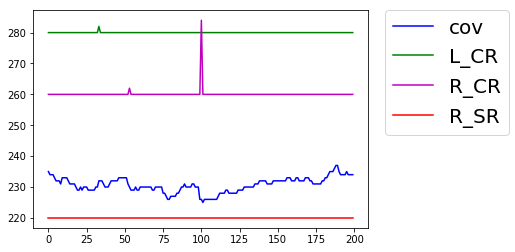

DEL_start id: 50


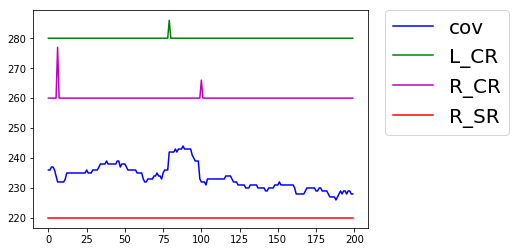

DEL_start id: 55


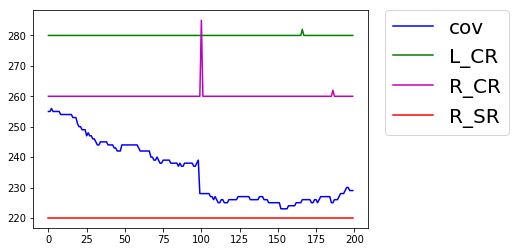

DEL_start id: 60


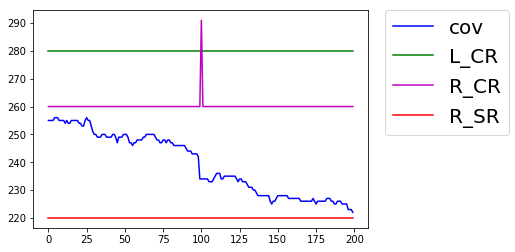

DEL_start id: 65


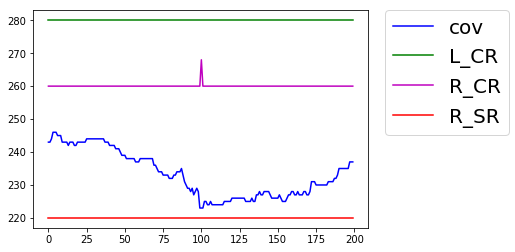

DEL_start id: 70


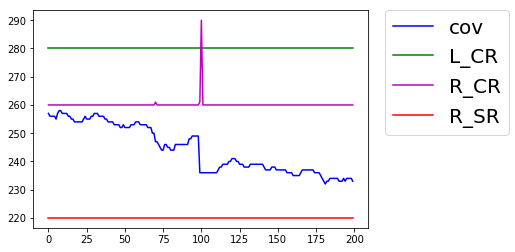

DEL_start id: 75


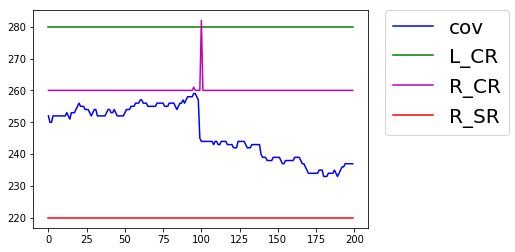

DEL_start id: 80


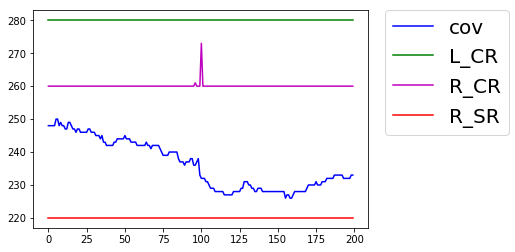

DEL_start id: 85


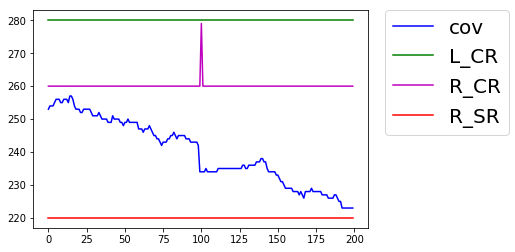

DEL_start id: 90


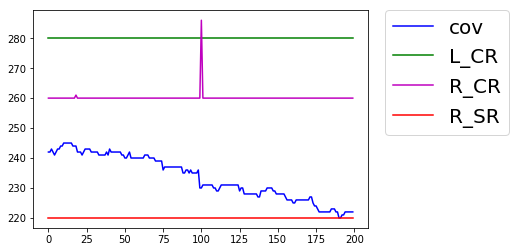

DEL_start id: 95


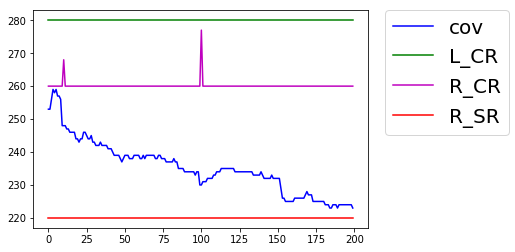

In [71]:
start_window = 0
print(n_windows)
#plot_channels(start_window, n_windows)

#print(Counter(y_train))

plot_channels(start_window, 100)

   
## Transposes every window in X, to comply to McFly format

In [19]:
def transposeDataset(X):
    image = []
    for i in range (0, len(X-1)):
        tr = X[i].transpose()
        image.append(tr)
    return np.array(image)

In [20]:
image1 = transposeDataset(X_train)
image2 = transposeDataset(X_val)
image3 = transposeDataset(X_test)
X_train = image1
X_val = image2
X_test = image3

n_channels = len(X_train[0][0])
print(len(X_test[0][0]))

38


## Prepare the labels in McFly format

In [21]:
classlabels = list(set(y_train))
mapclasses = {classlabels[i] : i for i in range(len(classlabels))}
print(mapclasses)

y_train = np.array([mapclasses[c] for c in y_train], dtype='int')
y_val = np.array([mapclasses[c] for c in y_val], dtype='int')
y_test = np.array([mapclasses[c] for c in y_test], dtype='int')

y_train_binary = to_categorical(y_train)
y_val_binary = to_categorical(y_val)
y_test_binary = to_categorical(y_test)

{'noSV': 0, 'DEL_start': 1, 'DEL_end': 2}


In [22]:
y_test_binary

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

## Generate neural networks architectures

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, MaxPooling1D
from keras.optimizers import Adam
import sys
import os
import numpy as np
sys.path.insert(0, os.path.abspath('..'))
from mcfly import modelgen, find_architecture

In [ ]:
#From https://stackoverflow.com/questions/43076609/how-to-calculate-precision-and-recall-in-keras

def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

precision = as_keras_metric(tf.metrics.precision)
recall = as_keras_metric(tf.metrics.recall)

In [29]:
np.random.seed = 321
num_classes = y_train_binary.shape[1]

In [30]:
%%time

models = modelgen.generate_models(X_train.shape,
                                  num_classes,
                                  number_of_models = 1,
                                  model_type = 'CNN',
                                  cnn_min_layers=2,
                                  cnn_max_layers=2,
                                  cnn_min_filters = 4, 
                                  cnn_max_filters = 4, 
                                  cnn_min_fc_nodes=6, 
                                  cnn_max_fc_nodes=6,
                                  low_lr=2, high_lr=2)



# models = modelgen.generate_models(X_train.shape,
#                                   num_classes,
#                                   number_of_models = 1,
#                                   model_type = 'DeepConvLSTM',
#                                   cnn_min_layers=1,
#                                   cnn_max_layers=1,
#                                   cnn_min_fc_nodes=4, 
#                                   cnn_max_fc_nodes=6,
#                                   low_lr=4, high_lr=4)

# models = modelgen.generate_models(X_train.shape,
#                                   num_classes,
#                                   number_of_models = 2,
#                                   model_type = 'CNN',
#                                   cnn_min_layers=2,
#                                   cnn_max_layers=3,
#                                   cnn_min_fc_nodes=4, 
#                                   cnn_max_fc_nodes=6,
#                                   low_lr=4, high_lr=4)

CPU times: user 579 ms, sys: 30.2 ms, total: 609 ms
Wall time: 608 ms


In [31]:
%%time
for model, params, model_types in models:
    print(params)
    model.summary()

{'learning_rate': 0.01, 'regularization_rate': 0.004155958290254745, 'filters': array([4, 4]), 'fc_hidden_nodes': 6}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 50, 38)            152       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 4)             460       
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 4)             16        
_________________________________________________________________
activation_1 (Activation)    (None, 50, 4)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 4)             52        
_________________________________________________________________
batch_normalization_3 (Batch (None, 50, 4)             16        
_________________________

## Train the networks

In [32]:
train_set_size = X_train.shape[0]
train_set_size

51207

In [33]:
print(datapath)

/hpc/cog_bioinf/ridder/users/lsantuari/Processed/Test/111018/50bp/TrainingData_111018/N1/ChannelData/


In [34]:
# Define directory where the results, e.g. json file, will be stored
resultpath = os.path.join(datapath, '../../data/models_DEL')
if not os.path.exists(resultpath):
        os.makedirs(resultpath)
print(resultpath)

/hpc/cog_bioinf/ridder/users/lsantuari/Processed/Test/111018/50bp/TrainingData_111018/N1/ChannelData/../../data/models_DEL


In [35]:
%%time
outputfile = os.path.join(resultpath, 'modelcomparison.json')
histories, val_accuracies, val_losses = find_architecture.train_models_on_samples(X_train, y_train_binary,
                                                                                  X_val, y_val_binary,
                                                                                  models,nr_epochs=1, 
                                                                                  subset_size=train_set_size,
                                                                                  verbose=True,
                                                                                  outputfile=outputfile)
                                                                                  #metric=['accuracy', precision, recall])
print('Details of the training process were stored in ',outputfile)

Training model 0 CNN
Train on 51207 samples, validate on 8532 samples
Epoch 1/1
51207/51207 [==============================] - 52s 1ms/step - loss: 0.0876 - acc: 0.9882 - val_loss: 0.0699 - val_acc: 0.9931
Details of the training process were stored in  /hpc/cog_bioinf/ridder/users/lsantuari/Processed/Test/111018/50bp/TrainingData_111018/N1/ChannelData/../../data/models_DEL/modelcomparison.json
CPU times: user 54.5 s, sys: 8.6 s, total: 1min 3s
Wall time: 53.1 s


## Plot training process

Currently run with a very low number of epochs

In [ ]:
#%%time
#for i in range(len(models)):
#    name = str(models[i][1])
#    find_architecture.plotTrainingProcess(histories[i], name)



In [36]:
#%%time
import pandas as pd
results = pd.DataFrame({'model':[str(params) for model, params, model_types in models],
                       'train_acc': [history.history['acc'][-1] for history in histories],
                       'train_loss': [history.history['loss'][-1] for history in histories],
                       'val_acc': [history.history['val_acc'][-1] for history in histories],
                       'val_loss': [history.history['val_loss'][-1] for history in histories]
                       })
results

,model,train_acc,train_loss,val_acc,val_loss
0,"{'learning_rate': 0.01, 'regularization_rate':...",0.988166,0.087571,0.993085,0.069928


## Take the best current model 

In [37]:
best_model_index = np.argmax(val_accuracies)

In [38]:
best_model, best_params, best_model_types = models[best_model_index]
print(best_model_index, best_model_types, best_params)

0 CNN {'learning_rate': 0.01, 'regularization_rate': 0.004155958290254745, 'filters': array([4, 4]), 'fc_hidden_nodes': 6}


## Save the best current model

In [39]:
from keras.models import load_model

model_path = os.path.join(resultpath, 'best_model')
print(model_path)

/hpc/cog_bioinf/ridder/users/lsantuari/Processed/Test/111018/50bp/TrainingData_111018/N1/ChannelData/../../data/models_DEL/best_model


In [40]:
best_model.save(model_path)

## Reload the best current model

In [41]:
model_reloaded = load_model(model_path)

## Test best current model on testset

### Overall accuracy on the test set:

In [42]:
score_test = model_reloaded.evaluate(X_test, y_test_binary, verbose=True)
print('Test loss and accuracy of best model: ' + str(score_test))

25608/25608 [==============================] - 6s 235us/step
Test loss and accuracy of best model: [0.06989702136627922, 0.9930490471727585]


### Re-check the train and validation scores: 

In [43]:
best_model.get_config()[0]

{'class_name': 'BatchNormalization',
 'config': {'name': 'batch_normalization_1',
  'trainable': True,
  'batch_input_shape': (None, 50, 38),
  'dtype': 'float32',
  'axis': -1,
  'momentum': 0.99,
  'epsilon': 0.001,
  'center': True,
  'scale': True,
  'beta_initializer': {'class_name': 'Zeros', 'config': {}},
  'gamma_initializer': {'class_name': 'Ones', 'config': {}},
  'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}},
  'moving_variance_initializer': {'class_name': 'Ones', 'config': {}},
  'beta_regularizer': None,
  'gamma_regularizer': None,
  'beta_constraint': None,
  'gamma_constraint': None}}

In [44]:
score_train = model_reloaded.evaluate(X_train, y_train_binary, verbose=True)
print('Train Score of best model: ' + str(score_train))

51207/51207 [==============================] - 11s 213us/step
Train Score of best model: [0.07001019975030341, 0.9928134825316851]


In [45]:
score_val = model_reloaded.evaluate(X_val, y_val_binary, verbose=True)
print('Val Score of best model: ' + str(score_val))

8532/8532 [==============================] - 2s 216us/step
Val Score of best model: [0.06992793030446535, 0.9930848570089077]


In [46]:
## Inspect model predictions on validation data
datasize = X_val.shape[0]
probs = model.predict_proba(X_val[:datasize,:,:],batch_size=1, verbose=True)

8532/8532 [==============================] - 54s 6ms/step


In [47]:
#columns are predicted, rows are truth
predicted = probs.argmax(axis=1)
#print(predicted)
y_index = y_val_binary.argmax(axis=1)
#print(y_index)
confusion_matrix = pd.crosstab(pd.Series(y_index), pd.Series(predicted))
confusion_matrix.index = [classlabels[i] for i in confusion_matrix.index]
confusion_matrix.columns = [classlabels[i] for i in confusion_matrix.columns]
confusion_matrix.reindex(columns=[l for l in classlabels], fill_value=0)
confusion_matrix

,noSV,DEL_start,DEL_end
noSV,2844,0,0
DEL_start,13,2819,12
DEL_end,23,11,2810


In [96]:
%%time
# Load data and labels
datapath_real ='/hpc/cog_bioinf/ridder/users/lsantuari/Processed/Test/'+date+'/TestData_'+date+'/NA12878/ChannelData/'

data_output_file = datapath_real + '../X.npy.gz'
with gzip.GzipFile(data_output_file, "rb") as f:
    data_real = np.load(f)
f.close()

CPU times: user 2min 25s, sys: 11 s, total: 2min 36s
Wall time: 2min 37s


In [97]:
label_output_file = datapath_real + '../y.npy.gz'
with gzip.GzipFile(label_output_file, "rb") as f:
    labels_real = np.load(f)
f.close()

In [98]:
data_real.shape

(1185753, 27, 200)

In [57]:
#Relabel deletions
del_idx = np.where(np.logical_or(np.array(labels_real)=='DEL_start',np.array(labels_real)=='DEL_end'))
print(del_idx)
print(len(del_idx))
print(len(labels_real))
labels_real[del_idx] = 'DEL'

(array([   3170,    5709,    7216, ..., 1184160, 1184162, 1185425]),)
1
1185753


In [99]:
keep = np.where(labels_real!='UK')

data_real = data_real[keep]
labels_real = labels_real[keep]

In [59]:
%%time

# Label unknown-UK as noSV?
#labels_real[np.where(labels_real=='UK')] = 'noSV'

#transpose X for McFly
X_test_real = transposeDataset(data_real)
y_test_real = labels_real

classlabels = list(set(y_test_real))
mapclasses = {classlabels[i] : i for i in range(len(classlabels))}
print(mapclasses)

y_test_real = np.array([mapclasses[c] for c in y_test_real], dtype='int')

{'DEL': 0, 'noSV': 1}
CPU times: user 19 s, sys: 26.5 s, total: 45.5 s
Wall time: 45.4 s


In [60]:
y_test_real_binary = to_categorical(y_test_real)

In [8]:
number_channels = data_real.shape[1]
print(number_channels)

label = ["None"] * number_channels

label[0] = "cov"
label[1] = "L_CR"
label[2] = "R_CR"

label[3] = "INV_B"
label[4] = "INV_A"
label[5] = "R_CR_DUP_B"
label[6] = "L_CR_DUP_A"

label[7] = "F_L_CR_sum"
label[8] = "F_L_CR_num"
label[9] = "F_L_CR_med"
label[10] = "F_R_CR_sum"
label[11] = "F_R_CR_num"
label[12] = "F_R_CR_med"

label[13] = "R_L_CR_dist_sum"
label[14] = "R_L_CR_dist_num"
label[15] = "R_L_CR_dist_med"
label[16] = "R_R_CR_dist_sum"
label[17] = "R_R_CR_dist_num"
label[18] = "R_R_CR_dist_med"

label[19] = "L_SR"
label[20] = "R_SR"

label[21] = "L_SR_dist_sum"
label[22] = "L_SR_dist_num"
label[23] = "L_SR_dist_med"

label[24] = "R_SR_dist_sum"
label[25] = "R_SR_dist_num"
label[26] = "R_SR_dist_med"

27


In [9]:
idx = np.where(labels_real!='noSV')
X_plot = data_real[idx]
labels_plot = labels_real[idx]

In [10]:
from numpy import *
import math
import matplotlib.pyplot as plt

colors =['b','g', 'm', 'gray', 'r','c', 'darkgreen' ,'y', 'k', 'orange', 'gray']

def plot_channels_real(start_window, n_windows):
    for i in range (start_window, start_window + n_windows, 5):
        print(labels_plot[i], 'id:', i)
        #print('id:', i)
        for j in range (0, number_channels):   
            if j in [3, 6, 14, 17]:
                continue
            shift = 0
            start =0
            if j in [0,11]:
                shift = -100
            if j > 10:
                start = -60
            Z = [start + shift + 300 + x - 5*j*4 for x in X_plot[i][j]]  
            #plt.ylim([100,700])
            if np.max(Z) > 1000:
                plt.ylim([-200,1000])
                Z = [start + shift + 300 + x - 5*j*4 - 400 for x in X_plot[i][j]]  
            if j>10:
                plt.plot(Z,  label = label[j], linestyle=':', linewidth=1.5, color = colors[j % 11])
            else:
                plt.plot(Z, label = label[j], color = colors[j])
        
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 5})    
        plt.show()

1185753
DEL_start id: 0


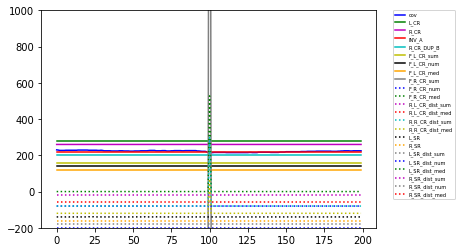

DEL_start id: 5


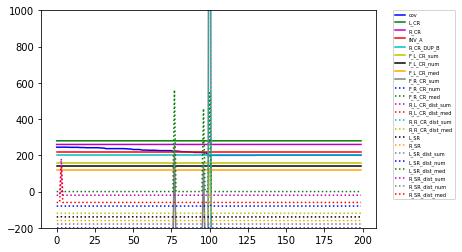

DEL_start id: 10


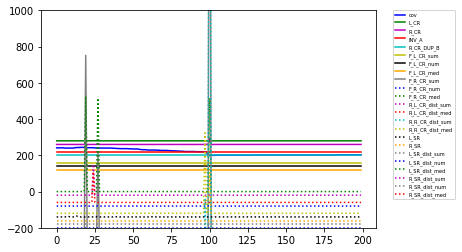

DEL_end id: 15


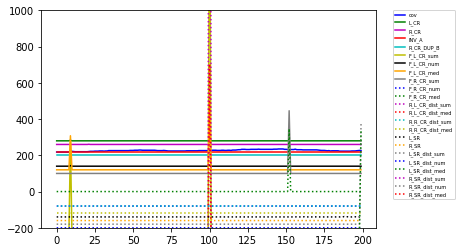

DEL_start id: 20


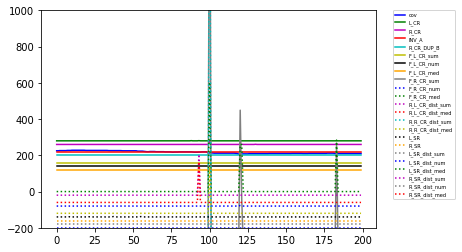

DEL_start id: 25


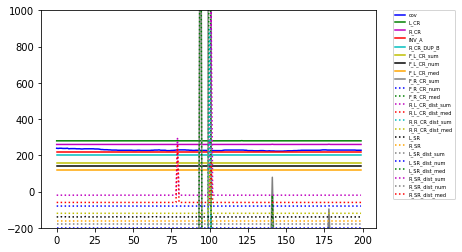

DEL_start id: 30


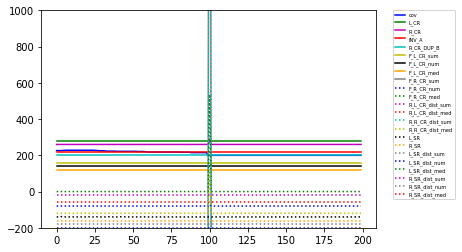

DEL_end id: 35


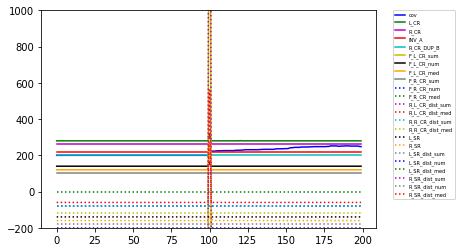

DEL_start id: 40


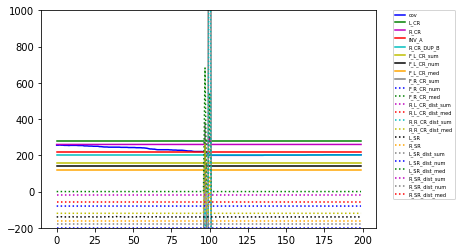

DEL_start id: 45


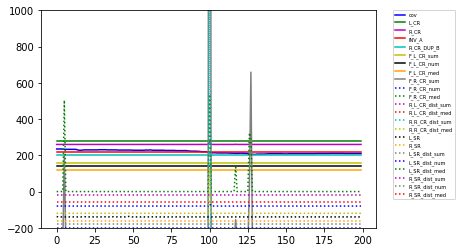

DEL_end id: 50


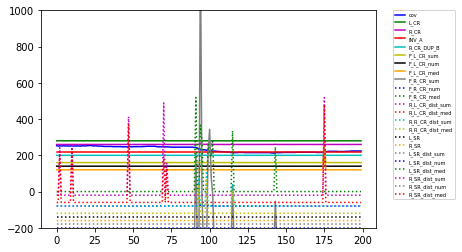

DEL_start id: 55


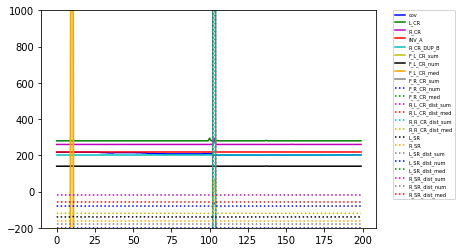

DEL_start id: 60


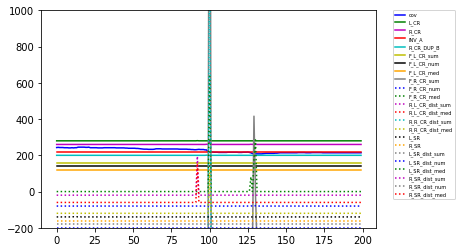

DEL_start id: 65


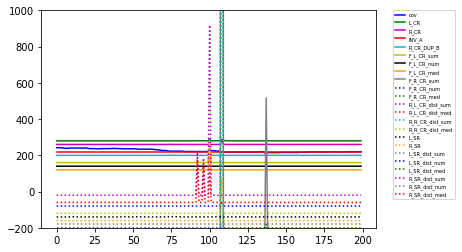

DEL_end id: 70


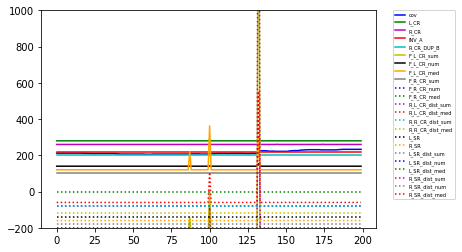

DEL_start id: 75


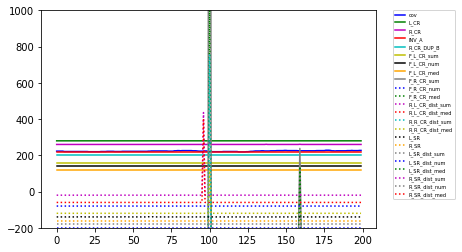

DEL_start id: 80


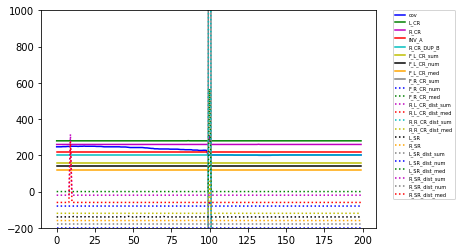

DEL_end id: 85


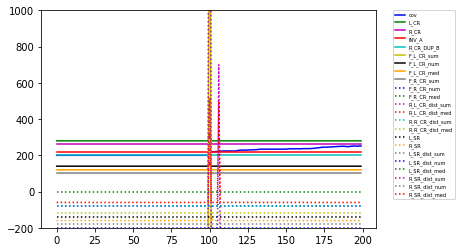

DEL_start id: 90


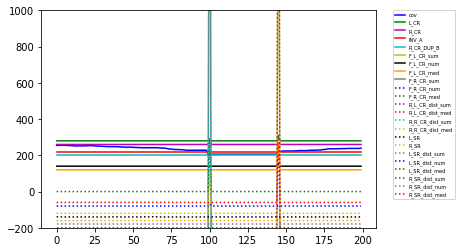

DEL_end id: 95


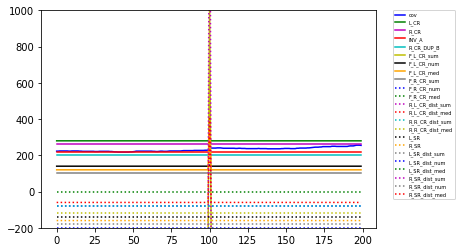

In [11]:
n_windows = X_test_real.shape[0]


start_window = 0
print(n_windows)
#plot_channels(start_window, n_windows)

#print(Counter(y_train))

plot_channels_real(start_window, 100)

In [61]:
score_test = model_reloaded.evaluate(X_test_real, y_test_real_binary, verbose=True)
print('Test loss and accuracy of best model: ' + str(score_test))

1184472/1184472 [==============================] - 116s 98us/step
Test loss and accuracy of best model: [3.649249800981518, 0.3222026354358735]


In [17]:
%%time
## Inspect model predictions on test data
datasize = X_test_real.shape[0]
probs = model_reloaded.predict_proba(X_test_real[:datasize,:,:],batch_size=1, verbose=True)

1185753/1185753 [==============================] - 1938s 2ms/step
CPU times: user 59min 31s, sys: 7min 41s, total: 1h 7min 12s
Wall time: 32min 17s


In [18]:
np.save(file=datapath_real + '../probs.npy', arr=probs)

In [21]:
import pandas as pd

#columns are predicted, rows are truth
predicted = probs.argmax(axis=1)
#print(predicted)
y_index = y_test_real_binary.argmax(axis=1)
#print(y_index)
confusion_matrix = pd.crosstab(pd.Series(y_index), pd.Series(predicted))
confusion_matrix.index = [classlabels[i] for i in confusion_matrix.index]
confusion_matrix.columns = [classlabels[i] for i in confusion_matrix.columns]
confusion_matrix.reindex(columns=[l for l in classlabels], fill_value=0)
confusion_matrix

,noSV,DEL_start,DEL_end
noSV,412456,497304,273831
DEL_start,1,1132,38
DEL_end,2,11,978


In [ ]:
#Balance and split dataset
data = data_real
labels = labels_real

In [ ]:
model_reloaded.fit(X_train, y_train_binary,
  epochs=25, validation_data=(X_val, y_val_binary))

In [ ]:
score_test = model_reloaded.evaluate(X_test, y_test_binary, verbose=True)
print('Test loss and accuracy of best model: ' + str(score_test))

In [46]:
#memory cleaning
del data
del labels